# 3. Layout detection and Order reading

**Author:** Manel Carrillo, 

**Mail** manelcarrillomaillo@gmail.com

## Imports

In [1]:
from PIL import Image
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Any
import os
from matplotlib import colormaps
from paddleocr import PaddleOCR
from IPython.display import display
import pandas as pd
from pytesseract import Output
from paddleocr import LayoutDetection
from PIL import Image, ImageOps, ImageEnhance

C:\Users\manel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `PADDLE_PDX_DISABLE_MODEL_SOURCE_CHECK` to `True`.


## Paths


In [2]:
ocr = PaddleOCR(lang='en')
PATH1 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_1.png'
PATH2 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_2.png'
PATH3 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_3.png'
PATH4 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_7.png'
PATH5 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/TFG1.png'

C:\Users\manel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\offici

## Functions from paddleOCR notebook

### 1 Plain OCR

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.


Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\en_PP-OCRv5_mobile_rec`.


text                                          |   conf | box
---------------------------------------------------------------------------------------
Abstract                                      |  1.000 | [[548, 919], [762, 916], [763, 965], [548, 968]]
1                                             |  1.000 | [[1220, 3167], [1252, 3167], [1252, 3211], [1220, 3211]]
NVIDIA et al., 2025).                         |  1.000 | [[1280, 1840], [1699, 1842], [1699, 1890], [1280, 1888]]
long-context performance, which is the scena… |  1.000 | [[183, 1831], [1115, 1827], [1116, 1878], [183, 1882]]
1. Introduction                               |  1.000 | [[1281, 916], [1645, 919], [1644, 968], [1281, 965]]
1NLP Group, DCST, IAI, BNRIST, Tsinghua Univ… |  0.999 | [[431, 631], [1782, 631], [1782, 685], [431, 685]]
trast, recurrent neural networks (RNNs) such… |  0.999 | [[1280, 1238], [2372, 1247], [2371, 1291], [1280, 1282]]
ever, these transfer methods require substan… |  0.999 | [[186, 1671], [1

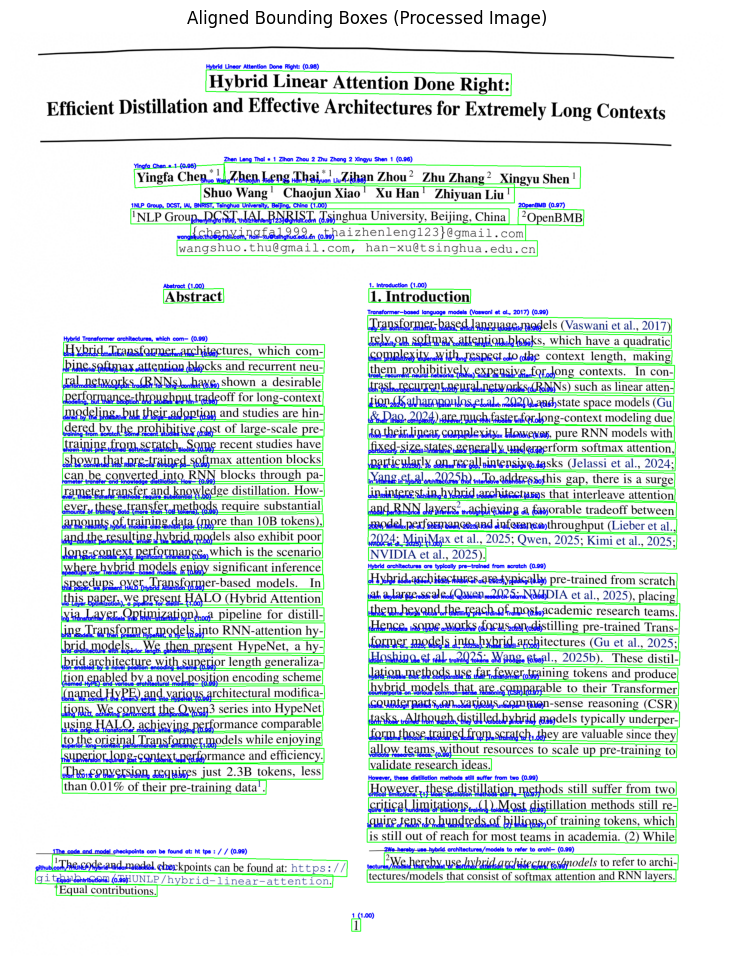

In [7]:
ocr = PaddleOCR(lang='en')
def extract_page_fields(result, page_idx=0):
    """Extract PaddleOCR page fields with basic validation."""
    if not result or page_idx >= len(result):
        raise ValueError(f"`result` is empty or page_idx={page_idx} out of range.")

    page = result[page_idx]
    required = ["rec_texts", "rec_scores", "rec_polys"]
    missing = [k for k in required if k not in page]
    if missing:
        raise KeyError(f"Missing keys in page dict: {missing}")

    texts  = page["rec_texts"]
    scores = page["rec_scores"]
    boxes  = page["rec_polys"]

    if not (len(texts) == len(scores) == len(boxes)):
        raise ValueError(
            f"Length mismatch: texts={len(texts)}, scores={len(scores)}, boxes={len(boxes)}"
        )

    # Image (optional)
    img = None
    try:
        img = page["doc_preprocessor_res"]["output_img"]
    except Exception:
        pass

    return page, texts, scores, boxes, img


def print_ocr_lines(texts, scores, boxes, min_score=0.0, top_k=None, text_width=40):
    """Pretty-print OCR results as a table-like output."""
    rows = []
    for t, s, b in zip(texts, scores, boxes):
        if s < min_score:
            continue
        coords = np.asarray(b).astype(int).tolist()
        rows.append((t, float(s), coords))

    # Sort by confidence (descending) if you want a "study" feel
    rows.sort(key=lambda x: x[1], reverse=True)

    if top_k is not None:
        rows = rows[:top_k]

    # Header
    print(f"{'text':{text_width}} | {'conf':>6} | box")
    print("-" * (text_width + 3 + 6 + 3 + 30))

    # Rows
    for t, s, coords in rows:
        t_fmt = (t[: text_width - 1] + "…") if len(t) > text_width else t
        print(f"{t_fmt:{text_width}} | {s:6.3f} | {coords}")


def draw_ocr_boxes(img, texts, boxes, scores=None, min_score=0.0,
                   box_thickness=2, font_scale=0.6):
    """
    Draw polygons + labels on a copy of img.
    If scores is given, filters by min_score.
    """
    if img is None:
        raise ValueError("No image available to draw on (img is None).")

    img_plot = img.copy()

    for i, (t, b) in enumerate(zip(texts, boxes)):
        s = scores[i] if scores is not None else 1.0
        if s < min_score:
            continue

        pts = np.asarray(b, dtype=int)

        # Draw polygon
        cv2.polylines(img_plot, [pts], isClosed=True, color=(0, 255, 0), thickness=box_thickness)

        x, y = int(pts[0][0]), int(pts[0][1])
        label = f"{t}"
        if scores is not None:
            label = f"{t} ({s:.2f})"

        cv2.putText(
            img_plot, label,
            (x, max(0, y - 6)),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale, (255, 0, 0), 2, cv2.LINE_AA
        )

    return img_plot
    
def show_image(img, title=None, figsize=(10, 12)):

    img_show = img
    if img.ndim == 3 and img.shape[2] == 3:
        img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=figsize)
    plt.imshow(img_show)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def run_paddle (image_path):
    result = ocr.predict(image_path)
    page, texts, scores, boxes, img = extract_page_fields(result, page_idx=0)
    print_ocr_lines(texts, scores, boxes, min_score=0.50, top_k=50, text_width=45)
    if img is not None:
        img_annot = draw_ocr_boxes(img, texts, boxes, scores=scores, min_score=0.50)
        show_image(img_annot, title="Aligned Bounding Boxes (Processed Image)")
    else:
        print("No preprocessed image found at page['doc_preprocessor_res']['output_img'].")
run_paddle(PATH1)

### 2 Layout Detection

In [3]:
layout_engine = LayoutDetection()

Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-DocLayout_plus-L`.


In [ ]:
def extract_layout_regions(
    image_path,
    layout_engine,
    min_confidence=0.0,
    sort_by="confidence"  # "confidence" | "top_to_bottom"
):
    """
    Run layout detection and return structured layout regions.

    Parameters
    ----------
    image_path : str or Path
        Path to input image.
    layout_engine : object
        PaddleOCR layout engine (already initialized).
    min_confidence : float
        Minimum confidence threshold.
    sort_by : str
        Sorting strategy:
        - "confidence": descending confidence
        - "top_to_bottom": reading-order-like (y, then x)

    Returns
    -------
    List[dict]
        Each dict contains: label, score, bbox, cx, cy
    """
    image_path = Path(image_path)
    if not image_path.exists():
        raise FileNotFoundError(f"Image not found: {image_path}")

    layout_result = layout_engine.predict(str(image_path))

    if not layout_result or "boxes" not in layout_result[0]:
        raise ValueError("Invalid layout detection output.")

    regions = []
    for box in layout_result[0]["boxes"]:
        score = float(box["score"])
        if score < min_confidence:
            continue

        x1, y1, x2, y2 = box["coordinate"]
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2

        regions.append({
            "label": box["label"],
            "score": score,
            "bbox": [x1, y1, x2, y2],
            "cx": cx,
            "cy": cy
        })

    if sort_by == "confidence":
        regions.sort(key=lambda r: r["score"], reverse=True)
    elif sort_by == "top_to_bottom":
        regions.sort(key=lambda r: (r["cy"], r["cx"]))
    else:
        raise ValueError(f"Unknown sort_by='{sort_by}'")

    return regions

def visualize_layout_regions(
    image_path,
    regions,
    figsize=(10, 12),
    show_labels=True,
    line_thickness=2,
    font_scale=0.6
):
    """
    Visualize layout regions on the image.

    Parameters
    ----------
    image_path : str or Path
        Path to input image.
    regions : List[dict]
        Output from extract_layout_regions.
    """
    image_path = Path(image_path)
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"cv2.imread failed for {image_path}")

    img_plot = img.copy()

    labels = sorted(set(r["label"] for r in regions))
    cmap = colormaps.get_cmap("tab20")

    color_map = {
        label: (
            int(cmap(i)[2] * 255),
            int(cmap(i)[1] * 255),
            int(cmap(i)[0] * 255),
        )
        for i, label in enumerate(labels)
    }

    for r in regions:
        x1, y1, x2, y2 = map(int, r["bbox"])
        color = color_map[r["label"]]

        pts = np.array(
            [[x1, y1], [x2, y1], [x2, y2], [x1, y2]],
            dtype=int
        )

        cv2.polylines(img_plot, [pts], True, color, line_thickness)

        if show_labels:
            text = f"{r['label']} ({r['score']:.2f})"
            cv2.putText(
                img_plot,
                text,
                (x1, max(0, y1 - 8)),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                color,
                2,
                cv2.LINE_AA
            )

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Layout Detection (PaddleOCR)")
    plt.show()

    return img_plot

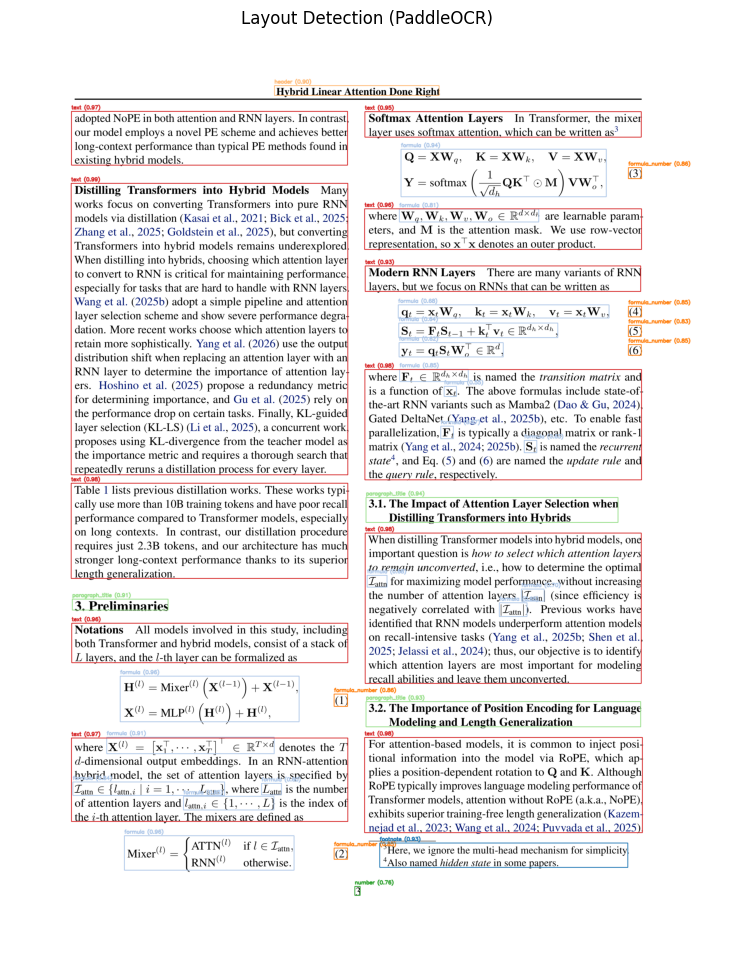

array([[[255, ..., 255],
        ...,
        [255, ..., 255]],

       ...,

       [[255, ..., 255],
        ...,
        [255, ..., 255]]], dtype=uint8)

In [5]:
regions = extract_layout_regions(
    image_path=PATH3,
    layout_engine=layout_engine,
    min_confidence=0.5,
    sort_by="top_to_bottom"
)

visualize_layout_regions(
    image_path=PATH3,
    regions=regions
)

In [ ]:
from transformers import LayoutLMv3ForTokenClassification
from layoutreader.v3.helpers import prepare_inputs, boxes2inputs, parse_logits

# Load LayoutReader model
print("Loading LayoutReader model...")
model_slug = "hantian/layoutreader"
layout_model = LayoutLMv3ForTokenClassification.from_pretrained(model_slug)
print("Model loaded successfully!")